In [1]:
import os
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

In [2]:
data_dir = 'data'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)
print(train_dataset)
type(train_dataset)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.89MB/s]

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train


torchvision.datasets.mnist.MNIST

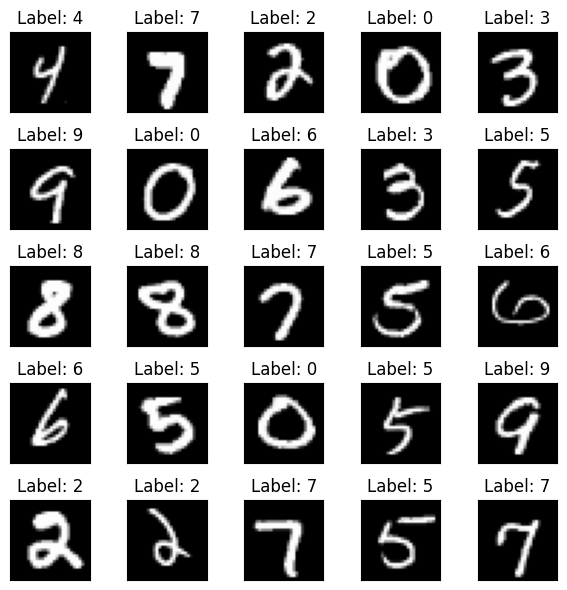

In [3]:
fig, axs = plt.subplots(5, 5, figsize=(6,6))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.03MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 64.4kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.15MB/s]


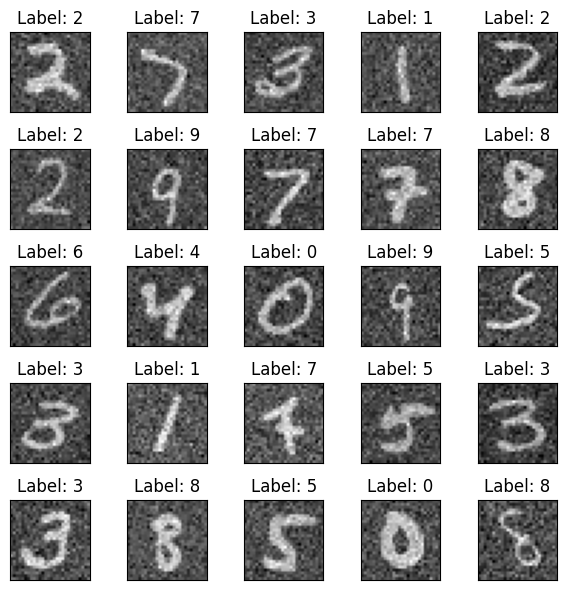

In [4]:
import torch
from torchvision import datasets, transforms

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        # Додаємо гаусівський шум до зображення
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

# Трансформації з додаванням шуму для обох датасетів
transform_with_noise = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(mean=0.05, std=0.2),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='path_to_data', train=True, download=True, transform=transform_with_noise)
test_dataset = datasets.MNIST (root='path_to_data', train=False, download=True, transform=transform_with_noise)

fig, axs = plt.subplots (5, 5, figsize=(6,6))
for ax in axs.flatten():
  img, label = random.choice(train_dataset)
  img = img * 0.5 + 0.5
  ax.imshow(np.array(img).squeeze(), cmap='gist_gray')
  ax.set_title(f'Label: {label}')
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()


In [5]:
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(len(train_dataset)*0.8), int(m*0.2)])



In [6]:
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [7]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()

        # Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        # Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        # Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [8]:
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim=128):
        super().__init__()

        # Linear section
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 7 * 7 * 16),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(16, 7, 7))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 4, stride=2, padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [9]:
# Set the random seed for reproducible results
torch.manual_seed(42)

# Initialize the two networks
encoded_space_dim = 4  # Розмір закодованого простору
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [10]:
img, _ = test_dataset[0]
img = img.unsqueeze(0)
print('Original image shape:', img.shape)

# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)


Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [11]:
# Define the loss function
loss_fn = torch.nn.MSELoss()

# Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)


Selected device: cuda


Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [12]:
decoder.to(device)


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(16, 7, 7))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [13]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader:
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


In [14]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[i][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()


\t partial train loss (single batch): 2.100110
\t partial train loss (single batch): 2.061291
\t partial train loss (single batch): 2.033775
\t partial train loss (single batch): 2.024821
\t partial train loss (single batch): 2.004818
\t partial train loss (single batch): 2.003073
\t partial train loss (single batch): 1.971408
\t partial train loss (single batch): 1.975464
\t partial train loss (single batch): 1.942791
\t partial train loss (single batch): 1.939264
\t partial train loss (single batch): 1.948990
\t partial train loss (single batch): 1.920842
\t partial train loss (single batch): 1.912315
\t partial train loss (single batch): 1.911180
\t partial train loss (single batch): 1.894699
\t partial train loss (single batch): 1.888206
\t partial train loss (single batch): 1.879511
\t partial train loss (single batch): 1.866805
\t partial train loss (single batch): 1.859349
\t partial train loss (single batch): 1.852954
\t partial train loss (single batch): 1.842634
\t partial tr

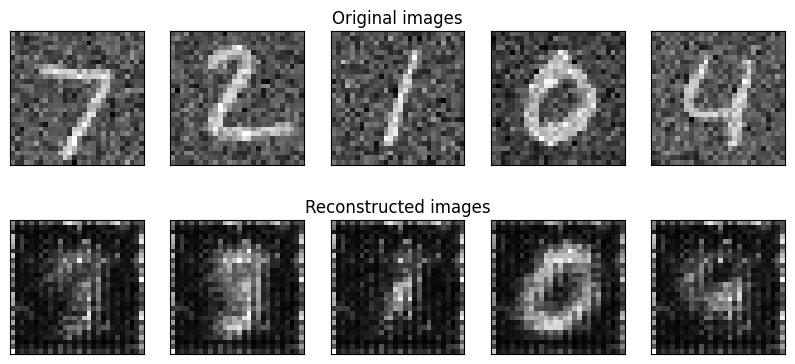

\t partial train loss (single batch): 1.073105
\t partial train loss (single batch): 1.068601
\t partial train loss (single batch): 1.070846
\t partial train loss (single batch): 1.067093
\t partial train loss (single batch): 1.066208
\t partial train loss (single batch): 1.065613
\t partial train loss (single batch): 1.061171
\t partial train loss (single batch): 1.062198
\t partial train loss (single batch): 1.059110
\t partial train loss (single batch): 1.056817
\t partial train loss (single batch): 1.062300
\t partial train loss (single batch): 1.059567
\t partial train loss (single batch): 1.055982
\t partial train loss (single batch): 1.051666
\t partial train loss (single batch): 1.054253
\t partial train loss (single batch): 1.053022
\t partial train loss (single batch): 1.050726
\t partial train loss (single batch): 1.048864
\t partial train loss (single batch): 1.047790
\t partial train loss (single batch): 1.046898
\t partial train loss (single batch): 1.044703
\t partial tr

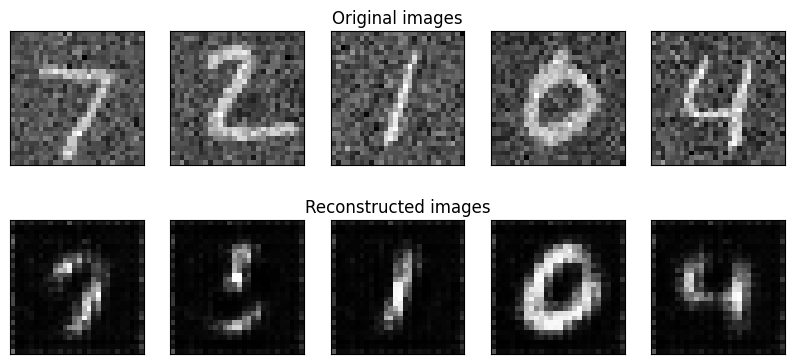

\t partial train loss (single batch): 0.953953
\t partial train loss (single batch): 0.947150
\t partial train loss (single batch): 0.948661
\t partial train loss (single batch): 0.951149
\t partial train loss (single batch): 0.946922
\t partial train loss (single batch): 0.951169
\t partial train loss (single batch): 0.946854
\t partial train loss (single batch): 0.952636
\t partial train loss (single batch): 0.950780
\t partial train loss (single batch): 0.948098
\t partial train loss (single batch): 0.948943
\t partial train loss (single batch): 0.948666
\t partial train loss (single batch): 0.950078
\t partial train loss (single batch): 0.950096
\t partial train loss (single batch): 0.944576
\t partial train loss (single batch): 0.947624
\t partial train loss (single batch): 0.946603
\t partial train loss (single batch): 0.948689
\t partial train loss (single batch): 0.949644
\t partial train loss (single batch): 0.949328
\t partial train loss (single batch): 0.950393
\t partial tr

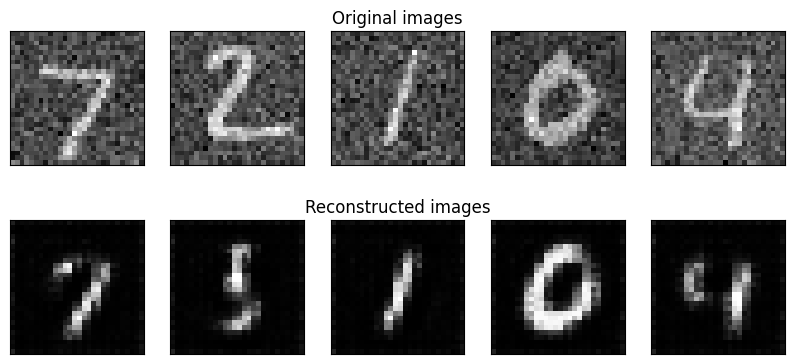

\t partial train loss (single batch): 0.930072
\t partial train loss (single batch): 0.928530
\t partial train loss (single batch): 0.927187
\t partial train loss (single batch): 0.927146
\t partial train loss (single batch): 0.931068
\t partial train loss (single batch): 0.926190
\t partial train loss (single batch): 0.928888
\t partial train loss (single batch): 0.932602
\t partial train loss (single batch): 0.927799
\t partial train loss (single batch): 0.930422
\t partial train loss (single batch): 0.931736
\t partial train loss (single batch): 0.925983
\t partial train loss (single batch): 0.930916
\t partial train loss (single batch): 0.927582
\t partial train loss (single batch): 0.925562
\t partial train loss (single batch): 0.929907
\t partial train loss (single batch): 0.929190
\t partial train loss (single batch): 0.927612
\t partial train loss (single batch): 0.929640
\t partial train loss (single batch): 0.927508
\t partial train loss (single batch): 0.927975
\t partial tr

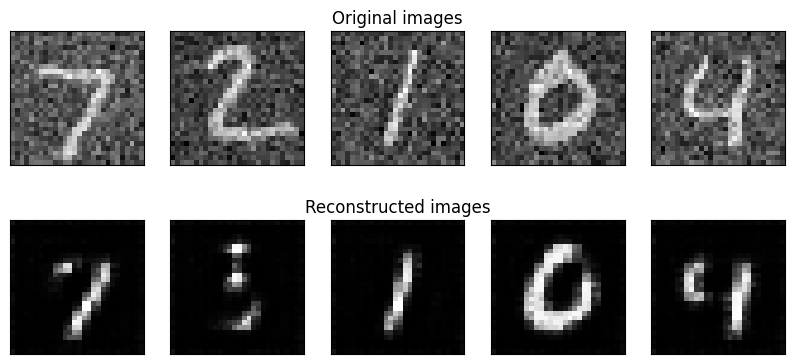

\t partial train loss (single batch): 0.922123
\t partial train loss (single batch): 0.920982
\t partial train loss (single batch): 0.917927
\t partial train loss (single batch): 0.920161
\t partial train loss (single batch): 0.916446
\t partial train loss (single batch): 0.918315
\t partial train loss (single batch): 0.917291
\t partial train loss (single batch): 0.920150
\t partial train loss (single batch): 0.920657
\t partial train loss (single batch): 0.919774
\t partial train loss (single batch): 0.923485
\t partial train loss (single batch): 0.923586
\t partial train loss (single batch): 0.923697
\t partial train loss (single batch): 0.918496
\t partial train loss (single batch): 0.920668
\t partial train loss (single batch): 0.922386
\t partial train loss (single batch): 0.918699
\t partial train loss (single batch): 0.918931
\t partial train loss (single batch): 0.919037
\t partial train loss (single batch): 0.916858
\t partial train loss (single batch): 0.917865
\t partial tr

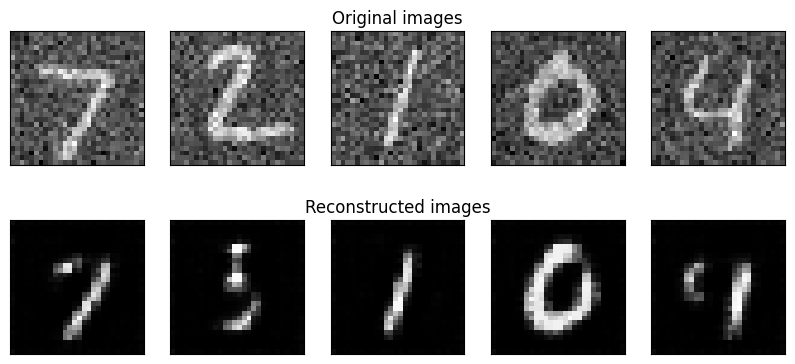

\t partial train loss (single batch): 0.916660
\t partial train loss (single batch): 0.914776
\t partial train loss (single batch): 0.914483
\t partial train loss (single batch): 0.915535
\t partial train loss (single batch): 0.915094
\t partial train loss (single batch): 0.916280
\t partial train loss (single batch): 0.914696
\t partial train loss (single batch): 0.915503
\t partial train loss (single batch): 0.915983
\t partial train loss (single batch): 0.912618
\t partial train loss (single batch): 0.918842
\t partial train loss (single batch): 0.915155
\t partial train loss (single batch): 0.914268
\t partial train loss (single batch): 0.916483
\t partial train loss (single batch): 0.916195
\t partial train loss (single batch): 0.917111
\t partial train loss (single batch): 0.918051
\t partial train loss (single batch): 0.915012
\t partial train loss (single batch): 0.914605
\t partial train loss (single batch): 0.917662
\t partial train loss (single batch): 0.916247
\t partial tr

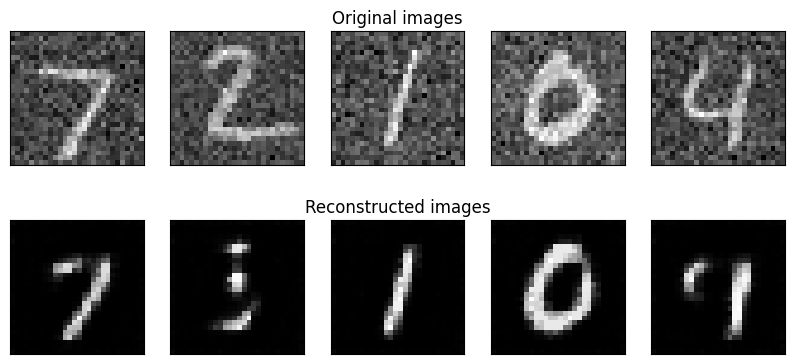

\t partial train loss (single batch): 0.915725
\t partial train loss (single batch): 0.912844
\t partial train loss (single batch): 0.912947
\t partial train loss (single batch): 0.915596
\t partial train loss (single batch): 0.912018
\t partial train loss (single batch): 0.915058
\t partial train loss (single batch): 0.911580
\t partial train loss (single batch): 0.914629
\t partial train loss (single batch): 0.912594
\t partial train loss (single batch): 0.912457
\t partial train loss (single batch): 0.912498
\t partial train loss (single batch): 0.916255
\t partial train loss (single batch): 0.913194
\t partial train loss (single batch): 0.911832
\t partial train loss (single batch): 0.913187
\t partial train loss (single batch): 0.915139
\t partial train loss (single batch): 0.911686
\t partial train loss (single batch): 0.914854
\t partial train loss (single batch): 0.913243
\t partial train loss (single batch): 0.912215
\t partial train loss (single batch): 0.913757
\t partial tr

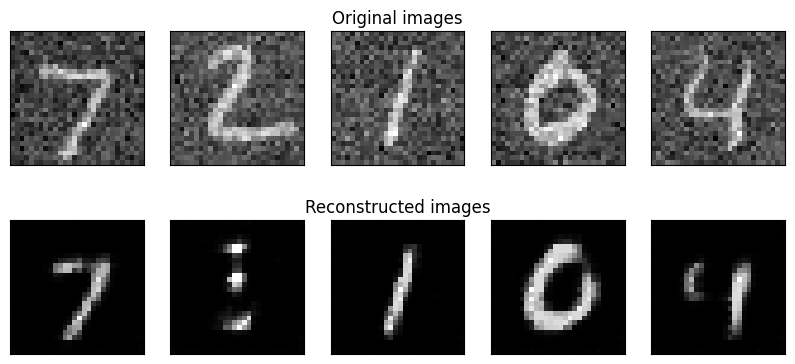

\t partial train loss (single batch): 0.913032
\t partial train loss (single batch): 0.906901
\t partial train loss (single batch): 0.906334
\t partial train loss (single batch): 0.908462
\t partial train loss (single batch): 0.909835
\t partial train loss (single batch): 0.908662
\t partial train loss (single batch): 0.908471
\t partial train loss (single batch): 0.912603
\t partial train loss (single batch): 0.909155
\t partial train loss (single batch): 0.907940
\t partial train loss (single batch): 0.912634
\t partial train loss (single batch): 0.909810
\t partial train loss (single batch): 0.907714
\t partial train loss (single batch): 0.906331
\t partial train loss (single batch): 0.908410
\t partial train loss (single batch): 0.909377
\t partial train loss (single batch): 0.909767
\t partial train loss (single batch): 0.910029
\t partial train loss (single batch): 0.909657
\t partial train loss (single batch): 0.911578
\t partial train loss (single batch): 0.911454
\t partial tr

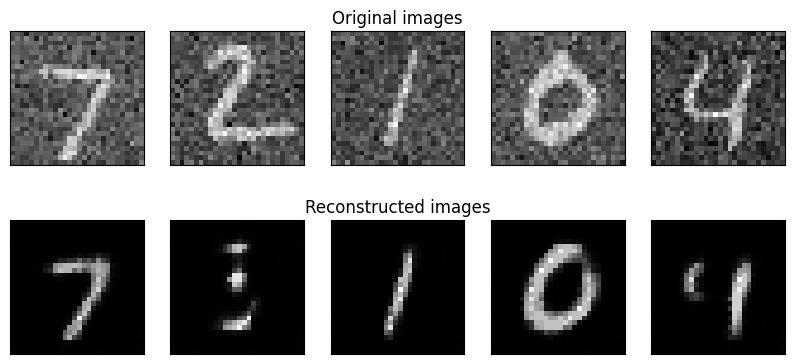

\t partial train loss (single batch): 0.910136
\t partial train loss (single batch): 0.905445
\t partial train loss (single batch): 0.907450
\t partial train loss (single batch): 0.911978
\t partial train loss (single batch): 0.906715
\t partial train loss (single batch): 0.907539
\t partial train loss (single batch): 0.904644
\t partial train loss (single batch): 0.912508
\t partial train loss (single batch): 0.906344
\t partial train loss (single batch): 0.906327
\t partial train loss (single batch): 0.908858
\t partial train loss (single batch): 0.905414
\t partial train loss (single batch): 0.908123
\t partial train loss (single batch): 0.904755
\t partial train loss (single batch): 0.908580
\t partial train loss (single batch): 0.908574
\t partial train loss (single batch): 0.905834
\t partial train loss (single batch): 0.906206
\t partial train loss (single batch): 0.910362
\t partial train loss (single batch): 0.906991
\t partial train loss (single batch): 0.910992
\t partial tr

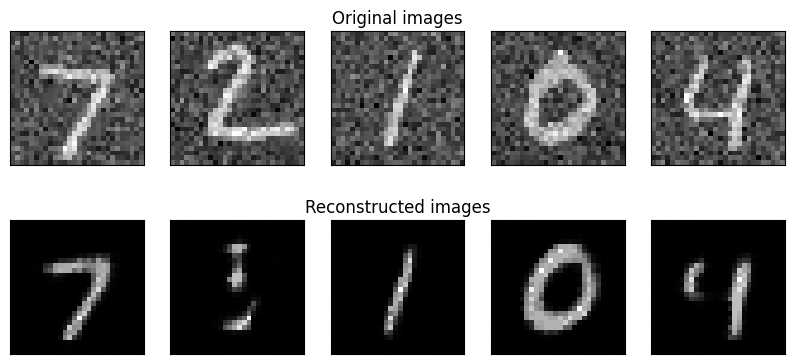

\t partial train loss (single batch): 0.905940
\t partial train loss (single batch): 0.902989
\t partial train loss (single batch): 0.906370
\t partial train loss (single batch): 0.905711
\t partial train loss (single batch): 0.904777
\t partial train loss (single batch): 0.906010
\t partial train loss (single batch): 0.904346
\t partial train loss (single batch): 0.907419
\t partial train loss (single batch): 0.905305
\t partial train loss (single batch): 0.906396
\t partial train loss (single batch): 0.908232
\t partial train loss (single batch): 0.904877
\t partial train loss (single batch): 0.904716
\t partial train loss (single batch): 0.905735
\t partial train loss (single batch): 0.905626
\t partial train loss (single batch): 0.907491
\t partial train loss (single batch): 0.905269
\t partial train loss (single batch): 0.903599
\t partial train loss (single batch): 0.906104
\t partial train loss (single batch): 0.905900
\t partial train loss (single batch): 0.908684
\t partial tr

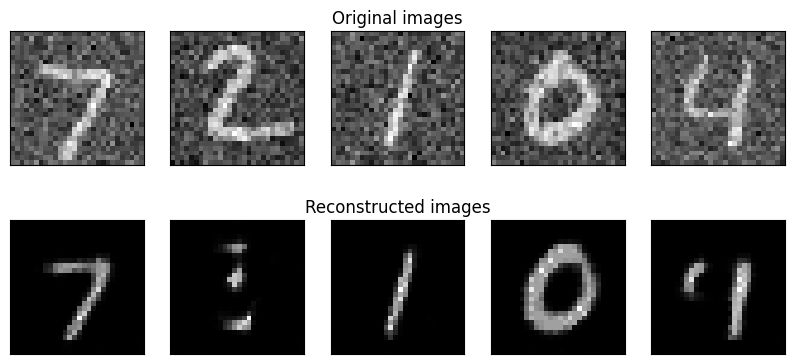

\t partial train loss (single batch): 0.905650
\t partial train loss (single batch): 0.902878
\t partial train loss (single batch): 0.903765
\t partial train loss (single batch): 0.906534
\t partial train loss (single batch): 0.903869
\t partial train loss (single batch): 0.903888
\t partial train loss (single batch): 0.901531
\t partial train loss (single batch): 0.904966
\t partial train loss (single batch): 0.901327
\t partial train loss (single batch): 0.904238
\t partial train loss (single batch): 0.906329
\t partial train loss (single batch): 0.907482
\t partial train loss (single batch): 0.902076
\t partial train loss (single batch): 0.899091
\t partial train loss (single batch): 0.905915
\t partial train loss (single batch): 0.905710
\t partial train loss (single batch): 0.904274
\t partial train loss (single batch): 0.903032
\t partial train loss (single batch): 0.903504
\t partial train loss (single batch): 0.905487
\t partial train loss (single batch): 0.905484
\t partial tr

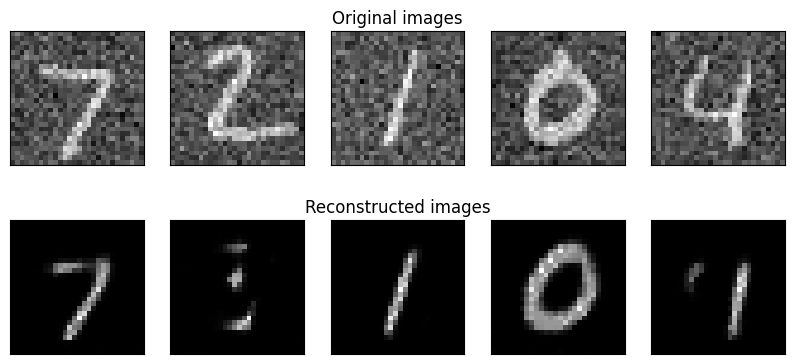

\t partial train loss (single batch): 0.904536
\t partial train loss (single batch): 0.900158
\t partial train loss (single batch): 0.901547
\t partial train loss (single batch): 0.906015
\t partial train loss (single batch): 0.899905
\t partial train loss (single batch): 0.904254
\t partial train loss (single batch): 0.901948
\t partial train loss (single batch): 0.900371
\t partial train loss (single batch): 0.896661
\t partial train loss (single batch): 0.902180
\t partial train loss (single batch): 0.902521
\t partial train loss (single batch): 0.902794
\t partial train loss (single batch): 0.899469
\t partial train loss (single batch): 0.897631
\t partial train loss (single batch): 0.903063
\t partial train loss (single batch): 0.903182
\t partial train loss (single batch): 0.898594
\t partial train loss (single batch): 0.902263
\t partial train loss (single batch): 0.904076
\t partial train loss (single batch): 0.901797
\t partial train loss (single batch): 0.903924
\t partial tr

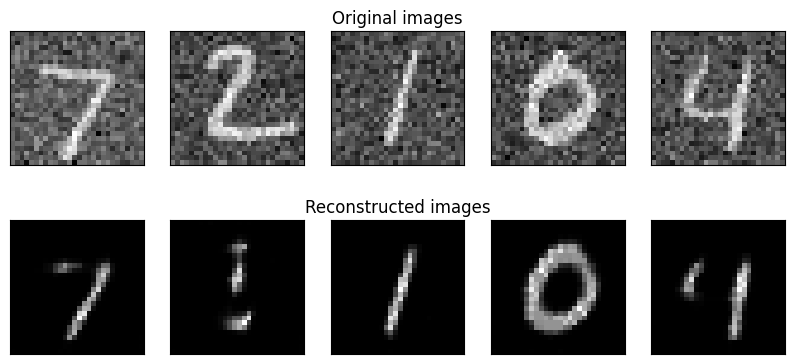

\t partial train loss (single batch): 0.902707
\t partial train loss (single batch): 0.897002
\t partial train loss (single batch): 0.900044
\t partial train loss (single batch): 0.901771
\t partial train loss (single batch): 0.899015
\t partial train loss (single batch): 0.901725
\t partial train loss (single batch): 0.900344
\t partial train loss (single batch): 0.899385
\t partial train loss (single batch): 0.900007
\t partial train loss (single batch): 0.899378
\t partial train loss (single batch): 0.902284
\t partial train loss (single batch): 0.900831
\t partial train loss (single batch): 0.898251
\t partial train loss (single batch): 0.900308
\t partial train loss (single batch): 0.902542
\t partial train loss (single batch): 0.897577
\t partial train loss (single batch): 0.899950
\t partial train loss (single batch): 0.900721
\t partial train loss (single batch): 0.904579
\t partial train loss (single batch): 0.901331
\t partial train loss (single batch): 0.902306
\t partial tr

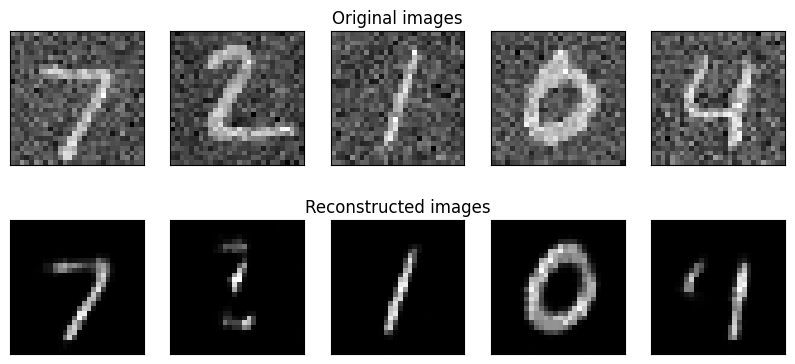

\t partial train loss (single batch): 0.899494
\t partial train loss (single batch): 0.894964
\t partial train loss (single batch): 0.897015
\t partial train loss (single batch): 0.900015
\t partial train loss (single batch): 0.898323
\t partial train loss (single batch): 0.899634
\t partial train loss (single batch): 0.894975
\t partial train loss (single batch): 0.898456
\t partial train loss (single batch): 0.901695
\t partial train loss (single batch): 0.897881
\t partial train loss (single batch): 0.902612
\t partial train loss (single batch): 0.899632
\t partial train loss (single batch): 0.896718
\t partial train loss (single batch): 0.898101
\t partial train loss (single batch): 0.896964
\t partial train loss (single batch): 0.898584
\t partial train loss (single batch): 0.899467
\t partial train loss (single batch): 0.894794
\t partial train loss (single batch): 0.897354
\t partial train loss (single batch): 0.899423
\t partial train loss (single batch): 0.902178
\t partial tr

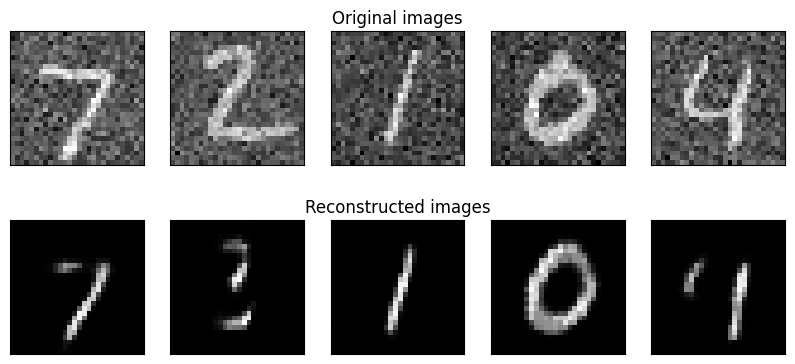

\t partial train loss (single batch): 0.898247
\t partial train loss (single batch): 0.896522
\t partial train loss (single batch): 0.896115
\t partial train loss (single batch): 0.897108
\t partial train loss (single batch): 0.897537
\t partial train loss (single batch): 0.900199
\t partial train loss (single batch): 0.893595
\t partial train loss (single batch): 0.896740
\t partial train loss (single batch): 0.898669
\t partial train loss (single batch): 0.897877
\t partial train loss (single batch): 0.896278
\t partial train loss (single batch): 0.897873
\t partial train loss (single batch): 0.898830
\t partial train loss (single batch): 0.895731
\t partial train loss (single batch): 0.896789
\t partial train loss (single batch): 0.896656
\t partial train loss (single batch): 0.895507
\t partial train loss (single batch): 0.897381
\t partial train loss (single batch): 0.897621
\t partial train loss (single batch): 0.897883
\t partial train loss (single batch): 0.900212
\t partial tr

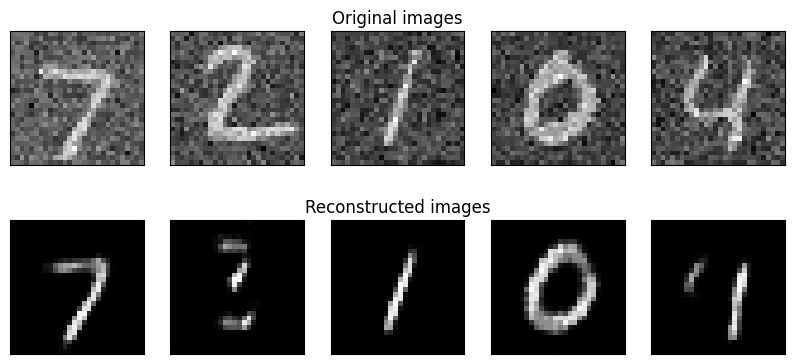

\t partial train loss (single batch): 0.897185
\t partial train loss (single batch): 0.895215
\t partial train loss (single batch): 0.894383
\t partial train loss (single batch): 0.895009
\t partial train loss (single batch): 0.894330
\t partial train loss (single batch): 0.898088
\t partial train loss (single batch): 0.891341
\t partial train loss (single batch): 0.896229
\t partial train loss (single batch): 0.894454
\t partial train loss (single batch): 0.897114
\t partial train loss (single batch): 0.897790
\t partial train loss (single batch): 0.894985
\t partial train loss (single batch): 0.896440
\t partial train loss (single batch): 0.894818
\t partial train loss (single batch): 0.894329
\t partial train loss (single batch): 0.893808
\t partial train loss (single batch): 0.893452
\t partial train loss (single batch): 0.896954
\t partial train loss (single batch): 0.895100
\t partial train loss (single batch): 0.897703
\t partial train loss (single batch): 0.900767
\t partial tr

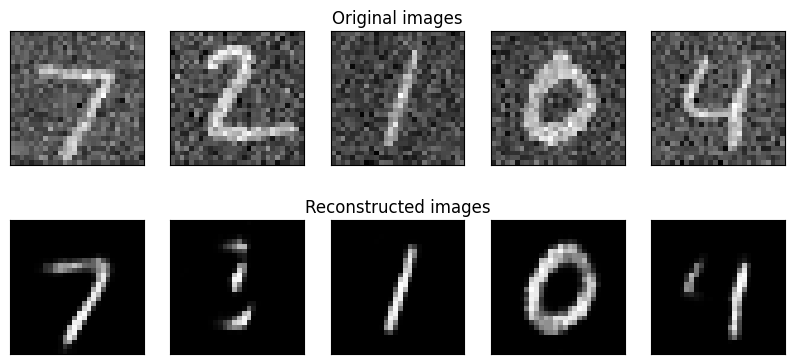

\t partial train loss (single batch): 0.896160
\t partial train loss (single batch): 0.893467
\t partial train loss (single batch): 0.895490
\t partial train loss (single batch): 0.895433
\t partial train loss (single batch): 0.894510
\t partial train loss (single batch): 0.894346
\t partial train loss (single batch): 0.894330
\t partial train loss (single batch): 0.895282
\t partial train loss (single batch): 0.895005
\t partial train loss (single batch): 0.892628
\t partial train loss (single batch): 0.895625
\t partial train loss (single batch): 0.895169
\t partial train loss (single batch): 0.894942
\t partial train loss (single batch): 0.895834
\t partial train loss (single batch): 0.894431
\t partial train loss (single batch): 0.896649
\t partial train loss (single batch): 0.892755
\t partial train loss (single batch): 0.893936
\t partial train loss (single batch): 0.893729
\t partial train loss (single batch): 0.898323
\t partial train loss (single batch): 0.894493
\t partial tr

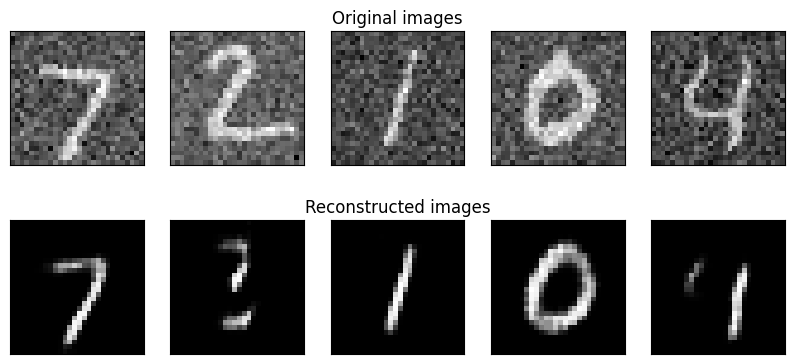

\t partial train loss (single batch): 0.895772
\t partial train loss (single batch): 0.894918
\t partial train loss (single batch): 0.893956
\t partial train loss (single batch): 0.892737
\t partial train loss (single batch): 0.889327
\t partial train loss (single batch): 0.893602
\t partial train loss (single batch): 0.893877
\t partial train loss (single batch): 0.896340
\t partial train loss (single batch): 0.893258
\t partial train loss (single batch): 0.893305
\t partial train loss (single batch): 0.894494
\t partial train loss (single batch): 0.893844
\t partial train loss (single batch): 0.892697
\t partial train loss (single batch): 0.894574
\t partial train loss (single batch): 0.896675
\t partial train loss (single batch): 0.896881
\t partial train loss (single batch): 0.892056
\t partial train loss (single batch): 0.895443
\t partial train loss (single batch): 0.894942
\t partial train loss (single batch): 0.895206
\t partial train loss (single batch): 0.894871
\t partial tr

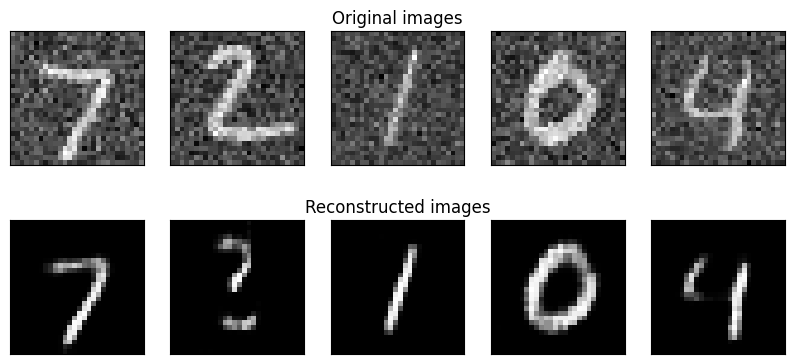

\t partial train loss (single batch): 0.897253
\t partial train loss (single batch): 0.891615
\t partial train loss (single batch): 0.892630
\t partial train loss (single batch): 0.895376
\t partial train loss (single batch): 0.891007
\t partial train loss (single batch): 0.893702
\t partial train loss (single batch): 0.894060
\t partial train loss (single batch): 0.891947
\t partial train loss (single batch): 0.891024
\t partial train loss (single batch): 0.893988
\t partial train loss (single batch): 0.893834
\t partial train loss (single batch): 0.890205
\t partial train loss (single batch): 0.891943
\t partial train loss (single batch): 0.893319
\t partial train loss (single batch): 0.893031
\t partial train loss (single batch): 0.893307
\t partial train loss (single batch): 0.890797
\t partial train loss (single batch): 0.891438
\t partial train loss (single batch): 0.892990
\t partial train loss (single batch): 0.892764
\t partial train loss (single batch): 0.896429
\t partial tr

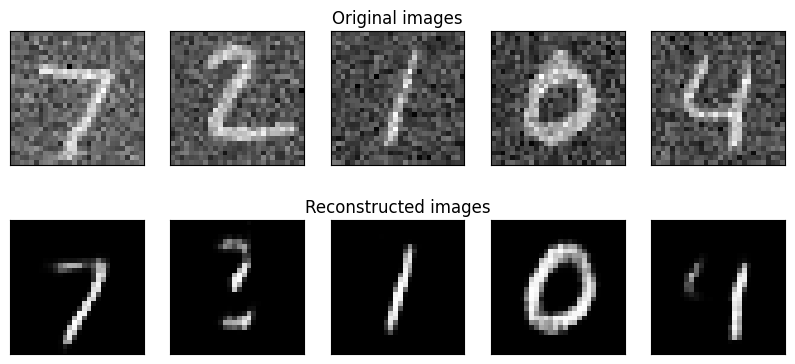

\t partial train loss (single batch): 0.896909
\t partial train loss (single batch): 0.890480
\t partial train loss (single batch): 0.891804
\t partial train loss (single batch): 0.890656
\t partial train loss (single batch): 0.894134
\t partial train loss (single batch): 0.894276
\t partial train loss (single batch): 0.892088
\t partial train loss (single batch): 0.892541
\t partial train loss (single batch): 0.891678
\t partial train loss (single batch): 0.894758
\t partial train loss (single batch): 0.895929
\t partial train loss (single batch): 0.893974
\t partial train loss (single batch): 0.892366
\t partial train loss (single batch): 0.892086
\t partial train loss (single batch): 0.891134
\t partial train loss (single batch): 0.891142
\t partial train loss (single batch): 0.891590
\t partial train loss (single batch): 0.893817
\t partial train loss (single batch): 0.891779
\t partial train loss (single batch): 0.893938
\t partial train loss (single batch): 0.893408
\t partial tr

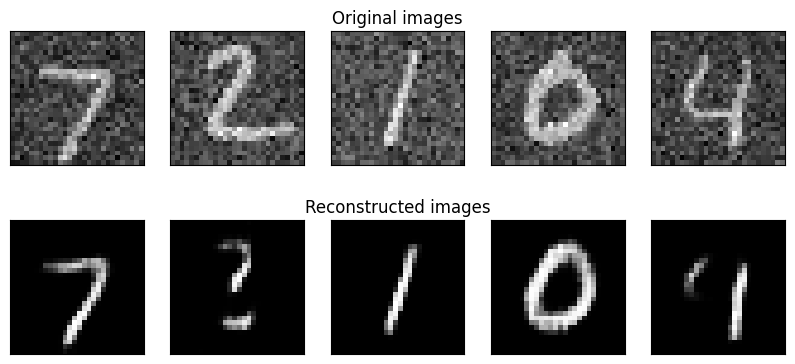

In [15]:
num_epochs = 20
history={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
    val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)

    print('\\n EPOCH {}/{} \\t train loss {:.3f} \\t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    plot_ae_outputs(encoder,decoder,n=5)


In [16]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()


0.8917587995529175

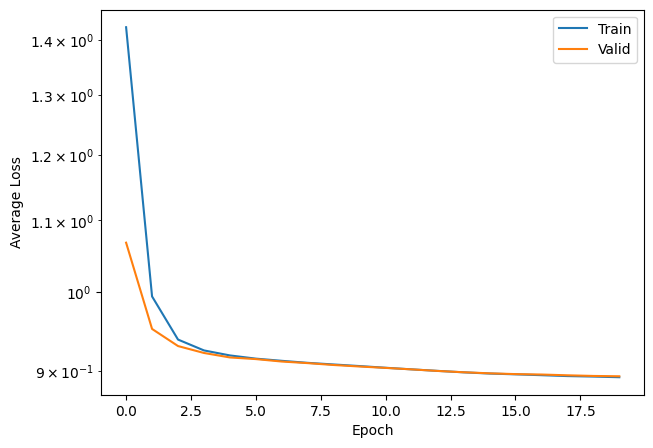

In [17]:
# Train and validation loss

plt.figure(figsize=(7,5))
plt.semilogy(history['train_loss'], label='Train')
plt.semilogy(history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()


**Висновок:** У цій лабораторній роботі було реалізовано автокодувальник для розпізнавання зображень рукописних цифр, після додавання гаусівського шуму. Модель складалась з енкодера та декодера, які були реалізовані за допомогою згорткових і лінійних шарів у PyTorch. Після побудови моделі була проведена її тренування та валідація на відповідних наборах даних. У процесі навчання фіксувалися значення функції втрат для навчальної та валідаційної вибірок, які були візуалізовані у вигляді графіка.